<a href="https://www.kaggle.com/code/imenbakir/part-ii-amazon-products-recommender-system?scriptVersionId=131082612" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="padding:10px;background-color:#FF9900;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Amazon products Recommendation System</p>

![im1](https://cdn.activestate.com/wp-content/uploads/2019/12/RecommendationEngine.png)

## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer,TFBertForSequenceClassification
%matplotlib inline

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:130%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Table Of Contents</p>   
    

    
|No  | Contents 
|:---| :---     
|1   | [<font color="#0f4c5c"> Sentiment Analysis </font>](#1)                  
|2   | [<font color="#0f4c5c">  Feature Extraction</font>](#2)                                  
|3   | [<font color="#0f4c5c">  Recommender System using transfer learning </font>](#3)              

<a id='1'></a>
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:170%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Sentiment Analysis</p>

In the previous [notebook](https://www.kaggle.com/code/imenbakir/nlp-amazon-products-recommender-system#Text-Pre-processing) I've conducted Text Pre-processing with techniques such as Removing punctuation, Converting text to lowercase, Tokenization, Lemmatization etc... and applied VADER to the dataset to categorize sentiment labels based on sentiment scores.

In this notebook I'm going to have a more in-depth application of **Rule-based Sentiment Analysis** with VADER on the clean dataset to analyze sentiments and categorize them into positive, neutral or negative.

I decided to take only reviews on software products from the original dataset

#### What is VADER ?

**VADER, or Valence Aware Dictionary and sEntiment :** is one of the most popular rule-based sentiment analysis methods, adjusted to the sentiments expressed on social media.


It performs better on content that you can discover on social media because it is tuned for social media content. As you can see in the example below, it still produces respectable F1 Scores on other test sets and performs similarly to more intricate statistical models like Support Vector Machines.

![img](https://miro.medium.com/v2/resize:fit:720/format:webp/1*cM3dLKxyh74V58Ay_HkTQg.png)

-Three-class Accuracy (F1 scores) for Each Machine Trained Model (Figure from the paper)
[1](https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-rule-based-vader-and-nltk-72067970fb71)

#### What is the purpose of VADER ?


To perform sentiment analysis on textual data, VADER can be applied for the purpose of assessing sentiments in social media messages, online reviews, and other brief and informal writings, it is a lexicon- and rule-based sentiment analysis tool.

The main goals of using VADER in sentiment analysis :

- Fine-grained sentiment analysis: It provides sentiment intensity scores for both positive and negative sentiments, allowing for a more nuanced understanding of sentiment polarity. It is meant to identify a target (topic) of a sentiment : A sentence is broken into phrases or clauses, and each part is analyzed in a connection with others.

- Handling of contextual cues: It takes into account factors like negation, emphasis, and punctuation to accurately assess the sentiment expressed in a piece of text.

- Domain adaptation: VADER's lexicon includes sentiment scores for a vast number of words, including slang, emoticons, and internet-specific jargon. This lexicon can be adapted or expanded to suit specific domains or contexts, making it flexible for sentiment analysis tasks across various domains.

- Fast and efficient analysis: VADER employs a rule-based approach, which makes it computationally efficient and suitable for real-time or large-scale sentiment analysis tasks.

#### Loading the dataset:

In [3]:
software_df = pd.read_csv('/kaggle/input/filtered-dataset/filtered_dataset.csv')

In [4]:
software_df.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_score,sentiment_label
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,0.34,positive


#### Assigning sentiment labels automatically without the help of VADER

In [5]:
columns = ['sentiment_score', 'sentiment_label']
software_df1 = software_df.drop(columns= columns , axis=1)

In [6]:
software_df1.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software


In [7]:
def assign_sentiment_label(score):
    """
     function to assign sentiment labels based on overall scores
    """
    
    if score >= 4:
        return 'positive'
    elif score < 3:
        return 'negative'
    else:
        return 'neutral'

#applying the function to create the sentiment_label column
software_df1['sentiment_label'] = software_df1['overall'].apply(assign_sentiment_label)

software_df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_label
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,positive
1,4,True,2014-02-23,A1YCCU0YRLS0FE,0077613252,Rosalind White Ames,really enjoying book worksheet make review goa...,health,software,positive
2,1,True,2014-02-17,A1BJHRQDYVAY2J,0077613252,Allan R. Baker,taking class do not waste money called book bo...,kiding,software,negative
3,3,True,2014-02-17,APRDVZ6QBIQXT,0077613252,Lucy,book missing page important page could not ans...,missing page,software,neutral
4,5,False,2013-10-14,A2JZTTBSLS1QXV,0077775473,Albert V.,used learnsmart officially say amazing study t...,best study product,software,positive


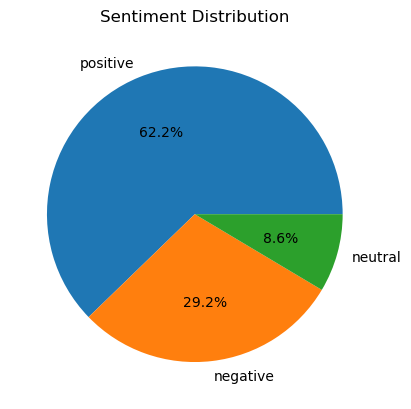

In [8]:
#count the number of reviews for each sentiment label
sentiment_counts1 = software_df1['sentiment_label'].value_counts()

plt.pie(sentiment_counts1, labels=sentiment_counts1.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show();

#### VADER

In [9]:
# Loading VADER Sentiment Intensity Analyzer
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**For testing purposes, let’s feed it a simple sentence with neutral and negative words**

In [10]:
sentences = ['Hello, world. I suck']
for word in sentences:
    print(word)
    ss = sia.polarity_scores(word)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')

Hello, world. I suck
compound: -0.4404, neg: 0.592, neu: 0.408, pos: 0.0, 

This model gave four scores: (1) Negativity, (2) Positivity, (3) Neutrality score of the sentence, and finally, (4) Compound sentiment score of the sentence. 

The compound score is basically an aggregated version of the first three scores, and we will be using this score to measure the sentiment of our reviews.

##### Calculating Polarity Scores and Predicting:

We were able to determine the sentiment score for a single sentence, now we need to execute a loop for the entire dataset.

We can shuffle the dataset before computing the scores : 

In [11]:
columns = ['sentiment_score', 'sentiment_label']
software_df2 = software_df.drop(columns= columns , axis=1)

In [12]:
# Shuffle data (Not really necessary, just for good practice)
software_slice = software_df2.sample(frac=1.0).reset_index(drop=True)

In [13]:
software_slice.head(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category
0,5,True,2017-03-20,AJBB5YKVRP9Z,B015724OVG,Amazon Customer,best antivirus market far price cannot beat,best antivirus price you will find,software
1,3,False,2003-03-30,AWAIGWW3F6H0Z,B00007E7II,Matthew Seitz,switched taxcut turbotax review said good turb...,disappointing good turbotax year ago,software
2,1,False,2010-09-17,A1FTRR0WV1H5K,B01F7RJHIQ,Mark Twain,thing except thigs do not work anymore like fr...,nothinnewhere,software
3,4,False,2013-11-10,ARFKEUHP5U0HN,B00E6LJ2SA,Roger H.,overall i am pleased product still unresolved ...,quicken little quirky,software
4,5,True,2012-12-05,A2TCVD6S0L4PZX,B008H3SW4I,kanakaiah,though bit difficult understand user interface...,found great o planet,software


##### Apply a lambda function on our dataset column reviewText and create a new column to save the results with the name sentiment_label :

First, I have encountered an error and it's due to the presence of null values in the 'reviewText' column (that was unexpected because I have already applied data pre processing in the previous notebook)

In [14]:
software_slice.isnull().sum()

overall            0
verified           0
reviewTime         0
reviewerID         0
asin               0
reviewerName       0
reviewText       555
summary         1192
category           0
dtype: int64

In [15]:
software_slice.duplicated().value_counts()

False    450856
True         13
dtype: int64

In [16]:
software_slice.drop_duplicates(inplace=True)

In [17]:
software_slice.duplicated().value_counts()

False    450856
dtype: int64

In [18]:
#replace NaN values with 'Unknown'
software_slice['reviewText'].fillna('Unknown', inplace=True)

In [19]:
software_slice['summary'].fillna('Unknown', inplace=True)

In [20]:
def analyze_sentiment(text):
    """
    Function to analyze the sentiment of a given text using VADER sentiment analyzer
    """
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

def categorize_sentiment(score):
    """
    Function to categorize the sentiment score into sentiment labels
    """
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

In [21]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 14.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=a54c578bff55e73203cb122414a30f56090cbae5ec1acb5d155ca06180f8bf48
  Stored in directory: /root/.cache/pip/wheels/6c/bd/3e/2d6afc9bc36c9975f8e4215a270bbac6580c4361ebd6bb2323
Successfully built swifter


In [22]:
import swifter

# Perform sentiment analysis on review text to generate sentiment scores
software_slice['sentiment_score'] = software_slice['reviewText'].swifter.apply(analyze_sentiment)

# Categorize sentiment scores into labels (e.g., positive, negative, neutral)
software_slice['sentiment_label'] = software_slice['sentiment_score'].swifter.apply(categorize_sentiment)

Pandas Apply:   0%|          | 0/450856 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

In [23]:
software_slice.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_score,sentiment_label
0,5,True,2017-03-20,AJBB5YKVRP9Z,B015724OVG,Amazon Customer,best antivirus market far price cannot beat,best antivirus price you will find,software,0.6369,positive


In [24]:
software_slice.sentiment_score.describe()

count    450856.000000
mean          0.435670
std           0.499831
min          -0.997200
25%           0.036100
50%           0.612400
75%           0.848100
max           0.999900
Name: sentiment_score, dtype: float64

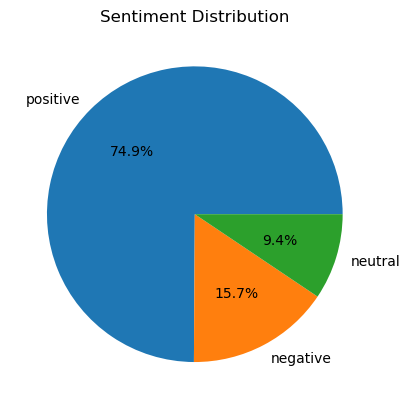

In [25]:
#count the number of reviews for each sentiment label
sentiment_counts = software_slice['sentiment_label'].value_counts()

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show();

##### Create a Confusion Matrix

Finally, I want to create a confusion matrix to properly measure our rule-based NLP sentiment classifier's success. 

A confusion matrix shows True Positives, True Negatives, False Positives, and False Negatives, which we can use to calculate Accuracy, Recall, Precision, and F1 Scores. 

With the lines below, I will create a custom function to generate confusion matrix tags and apply them as a lambda function

In [26]:
merged_df = pd.concat([software_df1['sentiment_label'], software_slice['sentiment_label']], axis=1, ignore_index=True, keys=['actual', 'predicted'])

In [27]:
merged_df.columns = ['actual_sentiment', 'predicted_sentiment']

In [28]:
merged_df.head()

,actual_sentiment,predicted_sentiment
0,positive,positive
1,positive,positive
2,negative,positive
3,neutral,positive
4,positive,positive


In [30]:
def conf_matrix(row):
    if row['actual_sentiment'] == 'positive' and row['predicted_sentiment'] == 'positive':
        return 'TP'
    elif row['actual_sentiment'] == 'positive' and row['predicted_sentiment'] == 'negative':
        return 'FN'
    elif row['actual_sentiment'] == 'negative' and row['predicted_sentiment'] == 'positive':
        return 'FP'
    elif row['actual_sentiment'] == 'negative' and row['predicted_sentiment'] == 'negative':
        return 'TN'
    else:
        return 0

# Create the 'Conf_Matrix' column using the conf_matrix function
merged_df['Conf_Matrix'] = merged_df.apply(conf_matrix, axis=1)

In [31]:
merged_df.head()

,actual_sentiment,predicted_sentiment,Conf_Matrix
0,positive,positive,TP
1,positive,positive,TP
2,negative,positive,FP
3,neutral,positive,0
4,positive,positive,TP


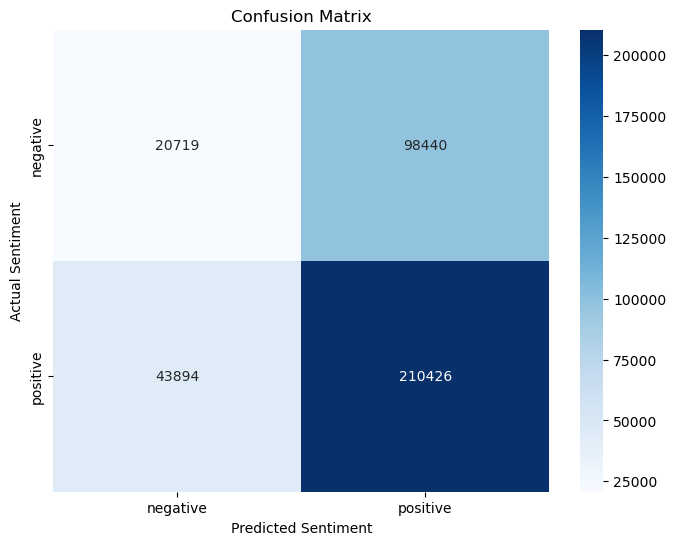

In [32]:
import seaborn as sns


# Filter out the rows with neutral labels
merged_df = merged_df[merged_df['Conf_Matrix'] != 0]

#a pivot table to get the counts
cm = pd.pivot_table(merged_df, index='actual_sentiment', columns='predicted_sentiment',
                                  values='Conf_Matrix', aggfunc='count', fill_value=0)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()

##### Calculating Accuracy, Recall, Precision, and F1 Score:

To see how we did with our VADER model, I will use several custom formulas to calculate Accuracy, Recall, Precision, and F1 Score.

In [33]:
merged_df.head()

,actual_sentiment,predicted_sentiment,Conf_Matrix
0,positive,positive,TP
1,positive,positive,TP
2,negative,positive,FP
4,positive,positive,TP
5,positive,positive,TP


In [34]:
conf_vals = merged_df.Conf_Matrix.value_counts().to_dict()
print(conf_vals)

{'TP': 210426, 'FP': 98440, 'FN': 43894, 'TN': 20719}


In [35]:
accuracy = (conf_vals['TP'] + conf_vals['TN']) / (conf_vals['TP'] + conf_vals['TN'] + conf_vals['FP'] + conf_vals['FN'])
precision = conf_vals['TP'] / (conf_vals['TP'] + conf_vals['FP'])
recall = conf_vals['TP'] / (conf_vals['TP'] + conf_vals['FN'])
f1_score = 2*precision*recall / (precision + recall)


print('Accuracy: ', round(100 * accuracy, 2),'%',
      '\nPrecision: ', round(100 * precision, 2),'%',
      '\nRecall: ', round(100 * recall, 2),'%',
      '\nF1 Score: ', round(100 * f1_score, 2),'%')

Accuracy:  61.89 % 
Precision:  68.13 % 
Recall:  82.74 % 
F1 Score:  74.73 %


VADER achieved a 61% accuracy on the amazon software products reviews. 

Don’t forget that VADER is a social-media lexicon. Therefore, using a software-reviews-based Lexicon would give us even higher performances.

<a id='2'></a>
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:170%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Feature Extraction</p>

In the context of sentiment analysis and building a recommender system based on user reviews, feature extraction refers to the process of **transforming textual data** (user reviews) into a **numerical representation** that can be used as **input** for **machine learning algorithms**.

Feature extraction involves selecting or extracting relevant information from the raw text that can capture the sentiment or characteristics of the reviews. 
The extracted features are then used to train models for sentiment analysis or to build recommendation systems.

There are several feature extraction techniques that can be used, some commonly used techniques include:

1. **Bag-of-Words (BoW):** It represents text as a collection of unique words, disregarding grammar and word order. Each word becomes a feature, and the frequency or presence of words in a document is used for analysis.

2. **Term Frequency-Inverse Document Frequency (TF-IDF):** It measures the importance of a word in a document by considering its frequency in the document and across the entire corpus. It assigns higher weights to rare words that are more informative.

3. **Word Embeddings:** such as Word2Vec or GloVe, capture the semantic meaning of words by representing them as dense vectors in a continuous space. These embeddings can be used as features to capture the contextual information and relationships between words.

4. **N-grams:** N-grams represent contiguous sequences of n words. They capture local word order and can provide more contextual information compared to BoW.

5. **Topic Modeling:** Techniques like Latent Dirichlet Allocation (LDA) can identify latent topics in a corpus. Topics can serve as features that capture the underlying themes in user reviews.

In [36]:
software_df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_label
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,positive
1,4,True,2014-02-23,A1YCCU0YRLS0FE,0077613252,Rosalind White Ames,really enjoying book worksheet make review goa...,health,software,positive
2,1,True,2014-02-17,A1BJHRQDYVAY2J,0077613252,Allan R. Baker,taking class do not waste money called book bo...,kiding,software,negative
3,3,True,2014-02-17,APRDVZ6QBIQXT,0077613252,Lucy,book missing page important page could not ans...,missing page,software,neutral
4,5,False,2013-10-14,A2JZTTBSLS1QXV,0077775473,Albert V.,used learnsmart officially say amazing study t...,best study product,software,positive


In [37]:
label_mapping = {"negative": 0, "positive": 1, "neutral": 2}
software_df1['sentiment_label'] = software_df1['sentiment_label'].map(label_mapping)

In [38]:
software_df1['sentiment_label'] 

0         1
1         1
2         0
3         2
4         1
         ..
450864    0
450865    0
450866    1
450867    1
450868    1
Name: sentiment_label, Length: 450869, dtype: int64

In [42]:
print("\nTotal number of reviews: ",len(software_df1))

print("=======================================================================")

print("\nTotal number of Sentiments: ", len(list(set(software_df1['sentiment_label'] ))))


Total number of reviews:  450869

Total number of Sentiments:  3


In [46]:
#software_df1.isnull().sum()

In [44]:
#replace NaN values with 'Unknown'
software_df1['reviewText'].fillna('Unknown', inplace=True)
software_df1['summary'].fillna('Unknown', inplace=True)

In [45]:
software_df1.isnull().sum()

overall            0
verified           0
reviewTime         0
reviewerID         0
asin               0
reviewerName       0
reviewText         0
summary            0
category           0
sentiment_label    0
dtype: int64

In [53]:
X_train, X_test, y_train, y_test = train_test_split(software_df1['reviewText'], software_df1['sentiment_label'], \
                                                    test_size=0.2, random_state=42)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])
print("=======================================================================")
print('Training Data : \n\n', X_train)
print("=======================================================================")
print('Testing data : \n\n', y_train)

Load 360695 training examples and 90174 validation examples. 

Show a review in the training set : 
 using turbotax year seems get easier every time use efile make even simpler
Training Data : 

 351553    program work well help beginner need met inqui...
433513    year back used earlier version music studio ha...
77504     i have tried figure rating antivirus software ...
374807    installed trial version downloaded franklincov...
420920    exactly ordered would recommend others looking...
                                ...                        
259178    installed window android device installation f...
365838    indeed best microsoft use word entourage must ...
131932    used word perfect since early always enjoyed u...
146867    work would recommend anyone loaded computer wo...
121958    cannot say enough love program many aspect pro...
Name: reviewText, Length: 360695, dtype: object
Testing data : 

 351553    1
433513    1
77504     0
374807    0
420920    1
         ..
259178

#### Bag of Words
<br>

**Step 1 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn**

**Step 2 : Transform review text to numerical representations (feature vectors)**

**Step 3 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)**

**Step 6 : Improve the model performance by GridSearch**

### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

In [56]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train)

In [60]:
#countVect.vocabulary_.values()

In [61]:
print("Number of features : %d \n" %len(countVect.get_feature_names_out()))
print("Show some feature names : \n", countVect.get_feature_names_out()[::1000])

Number of features : 160683 

Show some feature names : 
 ['aa' 'accuate' 'admended' 'agerange' 'allstatecom' 'amoritization'
 'antiapple' 'appleit' 'arseyou' 'attic' 'avalanche' 'badand' 'bben'
 'besteasiest' 'bju' 'bookds' 'breathiest' 'bullard' 'caeres' 'cardplus'
 'cdrws' 'cheapsoftware' 'citicard' 'cludginess' 'comepletely'
 'complexformated' 'conferencei' 'controla' 'cossack' 'creationist'
 'currentliving' 'databaseall' 'declan' 'demotivated'
 'developingengineering' 'dilute' 'dislike' 'dognew' 'downn' 'duddleberg'
 'easyi' 'eficiency' 'emphaze' 'entrtaning' 'etcnot' 'excitingits'
 'exspired' 'fantasy' 'fell' 'findersystem' 'flexibitliy' 'formatand'
 'freetype' 'functinality' 'garcia' 'gifspix' 'goofybut' 'greed'
 'hadperiod' 'hasalways' 'helpping' 'hiway' 'hoursattempts'
 'hrefkanaflashcardsdprefcmcrarpdrvwtxtieutfkana'
 'hreftrendmicroantivirusantispywaredpbcpjhgurefcmcrarpdrvwtxtieutftrend'
 'icloudsynchronized' 'imaginatively' 'incompetant' 'initiaited' 'instr'
 'intoout' 'is

In [64]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

MultinomialNB()

In [93]:
import pickle
pickle.dump(countVect,open('/kaggle/working/countVect.pkl','wb'))

In [79]:
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

def modelEvaluation(predictions):
    '''
    Print model evaluation for predicted results
    '''
    print("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nClassification report:\n", classification_report(y_test, predictions))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))


In [80]:
predictions = mnb.predict(countVect.transform(X_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.7934

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.75     26257
           1       0.84      0.90      0.87     56307
           2       0.29      0.06      0.10      7610

    accuracy                           0.79     90174
   macro avg       0.62      0.58      0.57     90174
weighted avg       0.76      0.79      0.77     90174


Confusion Matrix:
 [[20188  5514   555]
 [ 4871 50897   539]
 [ 2842  4311   457]]


In [94]:
import pickle
pickle.dump(mnb,open('Naive_Bayes_model.pkl','wb'))

### TfidfVectorizer with Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression


tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out()))
print("Show some feature names : \n", tfidf.get_feature_names_out()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 28748 

Show some feature names : 
 ['aa' 'angelic' 'baitandswitch' 'broaden' 'cissp' 'contribute' 'defense'
 'doorway' 'entrepreneur' 'filesthe' 'geek' 'heartbreaking' 'incase'
 'ivan' 'lined' 'memphis' 'mz' 'omg' 'pentax' 'prerelease' 'ranking'
 'resending' 'scrapbook' 'smack' 'streamer' 'terrable' 'tudor' 'utmost'
 'whose']


LogisticRegression()

**Note :**

if we set **min_df=5**, it means that a term must appear in at least 5 different reviews to be considered for TF-IDF calculation. Terms that appear in fewer than 5 reviews will be ignored and will not contribute to the TF-IDF values.

Setting a minimum document frequency can be useful to filter out very rare terms that may not provide much meaningful information or may introduce noise into the model. It helps to remove terms that may be too specific or unique to a small subset of documents.

In [85]:
import numpy as np 


feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['great' 'love' 'easy' 'excellent' 'best' 'beat' 'highly' 'flawlessly'
 'fantastic' 'overall']

Top 10 features with largest coefficients : 
['worst' 'useless' 'worthless' 'waste' 'worse' 'wasted' 'unusable'
 'terrible' 'awful' 'garbage']


In [86]:
predictions = lr.predict(tfidf.transform(X_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.8270

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     26257
           1       0.86      0.93      0.89     56307
           2       0.39      0.09      0.15      7610

    accuracy                           0.83     90174
   macro avg       0.68      0.61      0.61     90174
weighted avg       0.80      0.83      0.80     90174


Confusion Matrix:
 [[21279  4579   399]
 [ 3019 52608   680]
 [ 2772  4147   691]]


In [95]:
import pickle
pickle.dump(lr,open('Logistic_Regression_model.pkl','wb'))

### LSTM
<br>

**Step 1 : Prepare X_train and X_test to 2D tensor.**
    
**Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer).**
    
**Step 3 : Compile and fit the model using log loss function and ADAM optimizer.**

In [116]:
from tensorflow.keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from tensorflow.keras.utils import to_categorical

In [111]:
top_words = 40000
maxlen = 167
batch_size = 62
nb_classes = 3
nb_epoch = 6

# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words)  # only consider top_words words in the corpus
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [114]:
X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

In [117]:
# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, num_classes=nb_classes)
y_test_seq = to_categorical(y_test, num_classes=nb_classes)

print('X_train shape:', X_train_seq.shape)
print("========================================")
print('X_test shape:', X_test_seq.shape)
print("========================================")
print('y_train shape:', y_train_seq.shape)
print("========================================")
print('y_test shape:', y_test_seq.shape)
print("========================================")

X_train shape: (360695, 167)
X_test shape: (90174, 167)
y_train shape: (360695, 3)
y_test shape: (90174, 3)


In [123]:
y_train.unique()

array([1, 0, 2])

In [125]:
y_test.unique()

array([1, 0, 2])

In [124]:
model = Sequential()
model.add(Embedding(top_words, 128))
model.add(Dropout(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         5120000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 5,251,971
Trainable params: 5,251,971
Non-trainable params: 0
_________________________________________________________________


In [126]:
model.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

Epoch 1/6
  56/5818 [..............................] - ETA: 49:59 - loss: 0.8437 - accuracy: 0.6279

KeyboardInterrupt: 

In [ ]:
# Model evaluation
score = model.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

<a id='3'></a>
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:170%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Recommender System using transfer learning</p>

### 1. Fine Tuning BERT model

**What is BERT?**


Bidirectional Encoder Representation for Transformer (BERT) is an NLP model developed by Google Research in 2018, after its inception it has achieved state-of-the-art accuracy on several NLP tasks.

Transformer architecture has encoder and decoder stack, hence called encoder-decoder architecture whereas BERT is just an encoder stack of transformer architecture. There are two variants, BERT-base and BERT-large, which differ in architecture complexity. The base model has 12 layers in the encoder whereas the Large has 24 layers.

![bert](https://editor.analyticsvidhya.com/uploads/42979transformer_arch.png)

- Source : Transformer Architecture(https://arxiv.org/pdf/1706.03762.pdf)

![bert model](https://editor.analyticsvidhya.com/uploads/13789bert_architecture.png)

- Source: BERT Model(https://humboldtwi.github.io/blog/research/information_systems_1920/bert_blog_post/)

#### Tokenizing text

To find the maximum and average length of the text in the reviewText column.

The maximum length is important because it helps determine the input shape for the LSTM layer.

**Visualizing Text Distribution**

calculating the maximum sequence length for the text data in the 'reviewText' column

In [ ]:
import numpy as np

software_df1['txt_len'] = software_df1['reviewText'].apply(lambda x: len(x.split(" ")))
max_seq_len = np.round(software_df1['txt_len'].mean() + 2 * software_df1['txt_len'].std()).astype(int)
max_seq_len

In [ ]:
software_df1['txt_len'].plot.hist()
plt.xlim(0, 800)  # Set the x-axis limits
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.xlabel('Text Length')
plt.title('Text Length Distribution')
plt.show();

In [ ]:
software_df1.head()

#### Split data into Train and Test sets

In [ ]:
train_df, val_df = train_test_split(software_df1, test_size=0.2, random_state=42)

#### Tokenize text & padding

In [ ]:
example = software_df1['reviewText'][0]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.tokenize(example)

In [ ]:
tokenizer.encode(example)

Tokenize the text using the BERT tokenizer and convert it to input features:

The encode_plus  function of the tokenizer class will tokenize the raw input, add the special tokens, and pad the vector to a size equal to max length

#### Let’s prepare the data according to the format needed for the BERT model

**Input IDs** – The input ids are often the only required parameters to be passed to the model as input. Token indices, numerical representations of tokens building the sequences that will be used as input by the model.

**Attention mask** – Attention Mask is used to avoid performing attention on padding token indices. Mask value can be either 0 or 1, 1 for tokens that are NOT MASKED, 0 for MASKED tokens.

**Token type ids** – It is used in use cases like sequence classification or question answering. As these require two different sequences to be encoded in the same input IDs. Special tokens, such as the classifier[CLS] and separator[SEP] tokens are used to separate the sequences.

![bert input output](https://editor.analyticsvidhya.com/uploads/79452bert-text-classification-input.width-1280.png)

- Source: BERT Input/Output(https://pysnacks.com/machine-learning/bert-text-classification-with-fine-tuning/)

In [ ]:
def convert_review_to_feature(review):
    return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_seq_len, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

After tokenization, the resulting tokens are often converted into input features that can be used as numerical representations in the model. This step can be considered as part of the vectorization process, where the tokens are transformed into numerical vectors that capture the contextual information and semantic meaning of the text.

In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    """
    Transform raw data to an appropriate format ready to feed into the BERT model.
    """
    return {
          "input_ids": input_ids,
          "token_type_ids": token_type_ids,
          "attention_mask": attention_masks,
      }, label

In [ ]:
def encode_reviews(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
        
    for review, label in zip(ds['reviewText'], ds['sentiment_label']):
        bert_input = convert_review_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
batch_size=32

**Let’s form our train and test dataset**

In [ ]:
# train dataset
train_encoded = encode_reviews(train_df).shuffle(10000).batch(batch_size)
# test dataset
test_encoded = encode_reviews(val_df).batch(batch_size)

**Model Configuration**

In [ ]:
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.summary()

**Customizing the model's hyperparameters and optimizer:**

In [ ]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

number_of_epochs = 1

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

#### Training the BERT model for Sentiment Analysis

In [ ]:
train_encoded

In [52]:
bert_history = model.fit(train_encoded, epochs=1, validation_data=test_encoded)

UnimplementedError: Graph execution error:

Detected at node 'Cast_604' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_33/3149502789.py", line 1, in <module>
      bert_history = model.fit(train_encoded, epochs=number_of_epochs, validation_data=test_encoded)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1613, in train_step
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 676, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_604'
Cast string to float is not supported
	 [[{{node Cast_604}}]] [Op:__inference_train_function_39777]

#### Test on random sample

In [ ]:
test_sentence = "This is a really good product. I loved it and will buy again"

predict_input = tokenizer.encode(test_sentence,

truncation=True,

padding=True,

return_tensors="tf")
tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])